## This Notebook gives performs Data Splitting and Resizing of Images (to load in Google Drive - Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/computer vision/test_images.zip', 'r') as zip_ref:
    zip_ref.extractall('./test_images')
with zipfile.ZipFile('/content/drive/MyDrive/computer vision/train_images.zip', 'r') as zip_ref:
    zip_ref.extractall('./train_images')

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os

print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# sklearn libs..
from sklearn.model_selection import train_test_split

# DL Libs..
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  /content


#  <a id = 'section6'> <font color='red'>  6. Train Validation Split</font> </a>

In [ ]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
  train = pd.read_csv('/content/drive/MyDrive/computer vision/train.csv')
  test = pd.read_csv('/content/drive/MyDrive/computer vision/test.csv')

  train_dir = os.path.join('./','train_images/')
  test_dir = os.path.join('./','test_images/')

  train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
  test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

  train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
  test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

  train['diagnosis'] = train['diagnosis'].astype(str)

  return train, test

In [ ]:
df_train, df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./train_images/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,./train_images/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,./train_images/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,./train_images/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,./train_images/005b95c28852.png,005b95c28852.png
5,0083ee8054ee,4,./train_images/0083ee8054ee.png,0083ee8054ee.png


In [ ]:
df_train_train, df_train_valid = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_valid.shape)

(2929, 4) (733, 4)


In [ ]:
assert len(os.listdir('./test_images')) == 1928
assert len(os.listdir('./train_images')) == 3662

In [ ]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis', 'count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show()

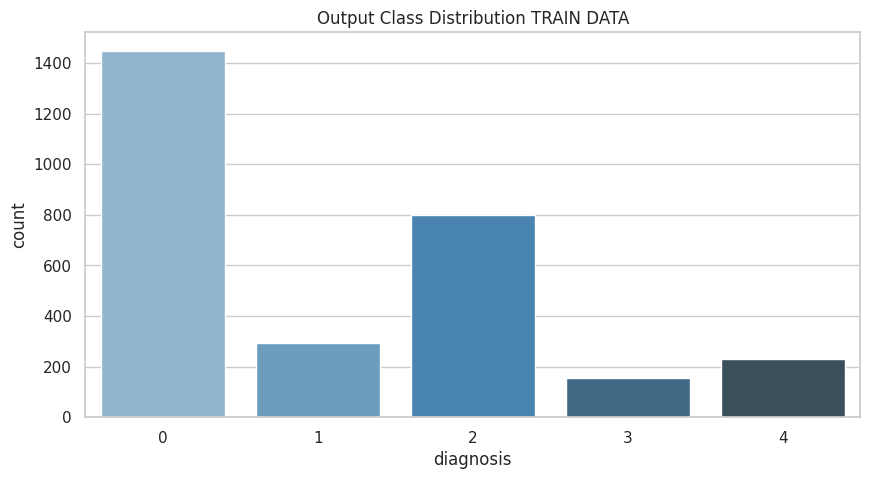

In [ ]:
plot_classes(df_train_train,"TRAIN DATA")

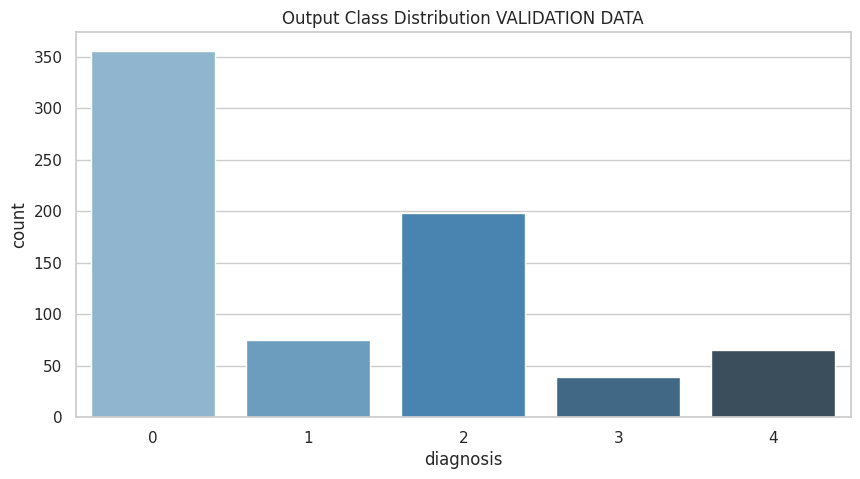

In [ ]:
plot_classes(df_train_valid,'VALIDATION DATA')

#  <a id = 'section7'> <font color='red'>  7. Resize and Save</font> </a>

In [ ]:
IMG_SIZE  = 512

In [ ]:
'''Function loads an image from Folder , Resizes and saves in another directory '''

def image_resize_save(dname, file):
  input_filepath = os.path.join('./', f'{dname}_images', f'{file}.png')
  output_filepath = os.path.join('/content/drive/MyDrive/computer vision/', f'{dname}_resized', f'{file}.png')
  if os.path.isdir(f'/content/drive/MyDrive/computer vision/{dname}_resized') == False:
    os.mkdir(f'/content/drive/MyDrive/computer vision/{dname}_resized')
  img = cv2.imread(input_filepath)
  cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
for id in df_train_train.id_code.values:
  image_resize_save('train', id)
for id in df_train_valid.id_code.values:
  image_resize_save('train', id)

In [ ]:
for id in df_train_valid.id_code.values:
  os.replace("/content/drive/MyDrive/computer vision/train_resized" + f"/{id}.png", "/content/drive/MyDrive/computer vision/valid_resized" + f"/{id}.png")

In [ ]:
for id in df_test.id_code.values:
  image_resize_save('test', id)

#  <a id = 'section8'> <font color='red'>  8. Image Pre Processing and save</font> </a>

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):
    """
    Create circular crop around image centre
    """
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img, 4, cv2.GaussianBlur(img , (0,0) , sigmaX), -4 , 128)
    return img

def preprocess_image(dname, file):
  input_filepath = os.path.join('/content/drive/MyDrive/computer vision/', f'{dname}_resized', f'{file}.png')
  output_filepath = os.path.join('/content/drive/MyDrive/computer vision/', f'{dname}_resized_preprocessed', f'{file}.png')
  if os.path.isdir(f'/content/drive/MyDrive/computer vision/{dname}_resized_preprocessed') == False:
    os.mkdir(f'/content/drive/MyDrive/computer vision/{dname}_resized_preprocessed')
  img = cv2.imread(input_filepath)
  img = circle_crop(img)
  cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
for id in df_train_train.id_code.values:
  preprocess_image('train', id)

In [ ]:
for id in df_train_valid.id_code.values:
  preprocess_image('valid', id)

In [ ]:
for id in df_test.id_code.values:
  preprocess_image('test', id)

(-0.5, 511.5, 511.5, -0.5)

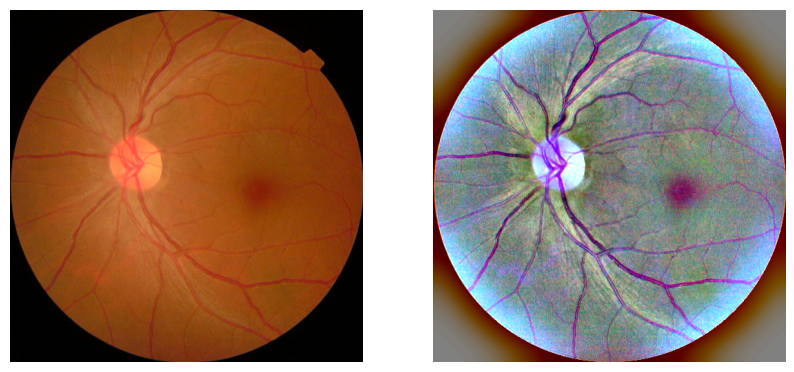

In [ ]:
import matplotlib.image as mpimg

path = '/content/drive/MyDrive/computer vision'
id = 'ff59d44a70a7'
image1_path = path + f'/train_resized/{id}.png'
image2_path = path + f'/train_resized_preprocessed/{id}.png'


img1 = mpimg.imread(image1_path)
img2 = mpimg.imread(image2_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img1)
ax[0].axis('off')

ax[1].imshow(img2)
ax[1].axis('off')